In [1]:
from sklearn.preprocessing import OrdinalEncoder #This converts the categorical features in your data into numerical features

In [66]:
!pip install tf-models-official

In [3]:
!pip install transformers #Provides a comprehensive set of tools and models for working with transformer-based architectures in natural language processing (NLP).

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
import shutil
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from tensorflow.keras import layers

In [6]:
tf.config.run_functions_eagerly(True)

In [7]:
DATA_PATH = os.path.join("/content", 'drive', 'MyDrive', 'Cyberbully', 'cyberbullying_tweets.csv')
df = pd.read_csv(DATA_PATH)
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [8]:
df.groupby("cyberbullying_type").count()

,tweet_text
cyberbullying_type,
age,7992
ethnicity,7961
gender,7973
not_cyberbullying,7945
other_cyberbullying,7823
religion,7998


In [9]:

ord = OrdinalEncoder()
df[['cyberbullying_type']] = ord.fit_transform(df[["cyberbullying_type"]])
LABEL_CAT = ord.categories_

In [10]:
df = df.astype({'cyberbullying_type':'int32', 'tweet_text':'string'})

In [11]:
print(LABEL_CAT)
df.sample(10)

[array(['age', 'ethnicity', 'gender', 'not_cyberbullying',
       'other_cyberbullying', 'religion'], dtype=object)]


,tweet_text,cyberbullying_type
42925,@b_bquiet @thelakeshowking Learn how to spell ...,1
1235,RT @AaronDagloria: @YesYoureSexist @DammitBode...,3
18678,#LiberalParty #Trudeau AT IT AGAIN! EVERY UNIO...,5
6868,"ée vo sar aqi, deixar o bully baixando..",3
32504,I cannot wait to go back 2 school i am going t...,0
1742,"Niñas, reinas del “bullying” en escuelas priva...",3
47107,@PauIGeorgeLeg dumb fuck I said nigga not nigg...,1
32778,Just found out the girl who bullied me in high...,0
20685,RT @usaone0: @AmyMek Proper Grammer :Islam pho...,5
23901,Here comes a person in defence of Islamic terr...,5


In [12]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(df['tweet_text'])

In [13]:
@tf.function
def tokenize(tensor):
  return tokenizer.texts_to_sequences(tensor)

In [14]:
df['tokenized'] = tokenize(df['tweet_text'])

In [15]:
#It calculates the number of zeros needed to pad the list to reach max_len using: padding = max_len - len(lst)
def pad_list(lst, max_len):
    padded = lst + [0] * (max_len - len(lst))
    return padded

max_len = 300
df['tokenized'] = df['tokenized'].map(lambda x : pad_list(x, max_len))

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit

strat_tt = StratifiedShuffleSplit(n_splits=1, test_size=0.1)
for id_train_val, id_test in strat_tt.split(df[['tokenized', 'tweet_text']], df['cyberbullying_type']):
    df_train_val = df.loc[id_train_val]
    df_test = df.loc[id_test]

df_train_val.reset_index(drop=True, inplace=True)

strat_tv = StratifiedShuffleSplit(n_splits=1, test_size=1/9)
for id_train, id_val in strat_tv.split(df_train_val[['tokenized', 'tweet_text']], df_train_val['cyberbullying_type']):
    df_train = df_train_val.loc[id_train]
    df_val = df_train_val.loc[id_val]

In [17]:
df["tweet_text"]

0        In other words #katandandre, your food was cra...
1        Why is #aussietv so white? #MKR #theblock #ImA...
2        @XochitlSuckkks a classy whore? Or more red ve...
3        @Jason_Gio meh. :P  thanks for the heads up, b...
4        @RudhoeEnglish This is an ISIS account pretend...
                               ...                        
47687    Black ppl aren't expected to do anything, depe...
47688    Turner did not withhold his disappointment. Tu...
47689    I swear to God. This dumb nigger bitch. I have...
47690    Yea fuck you RT @therealexel: IF YOURE A NIGGE...
47691    Bro. U gotta chill RT @CHILLShrammy: Dog FUCK ...
Name: tweet_text, Length: 47692, dtype: string

In [69]:
import pickle

# Save the tokenizer to a file
tokenizer_save_path = '/content/drive/MyDrive/tokenizer.pkl'
with open(tokenizer_save_path, 'wb') as f:
    pickle.dump(tokenizer, f)


In [18]:
BATCH_SIZE = 64

train_ds = tf.data.Dataset.from_tensor_slices(
    (df_train['tweet_text'].values, df_train['cyberbullying_type'].values)
).batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices(
    (df_test['tweet_text'].values, df_test['cyberbullying_type'].values)
).batch(BATCH_SIZE)

val_ds = tf.data.Dataset.from_tensor_slices(
    (df_val['tweet_text'].values, df_val['cyberbullying_type'].values)
).batch(BATCH_SIZE)

In [19]:
for text, label in train_ds:
    print(text)
    print(label.numpy())
    break

tf.Tensor(
[b'for shopping at value village in jr high. just saw the girl who bullied me for it post a thrift haul on her ig story &lt;3'
 b"Not even the roaches &amp; rodents would eat Kat &amp; Andre's food ! #RSPCA #crueltytoanimals #mkr"
 b"HELL. Now they'll know I've been your sockpuppet all along. @TheQuinnspiracy"
 b'Hey @PeteButtigieg You can\'t say it\'s "immoral" for Christians not to support radical environmentalism when you support killing children in abortions up to birth. Until you stop supporting abortion you have no moral authority. http://bit.ly/2Lp3Sta'
 b'RT @Kiri13: Catching up on last nights #MKR and yes Kat &amp; Andre are super annoying! \xf0\x9f\x98\xa1\xf0\x9f\x98\xa4'
 b'He pulled so many manipulative moves in his "apology" video. He nearly addressed the paedophilia, rape comments and his multiple jokes about eugenia cooneys eating disorder. They arent just little jokes anymore. It doesnt matter if hes gay, or famous. He did this to himself.'
 b"@MiinT tweetin

In [20]:
train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, 6)))
test_ds = test_ds.map(lambda x, y: (x, tf.one_hot(y, 6)))
val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, 6)))

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [21]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [22]:
bert_preprocess = hub.KerasLayer(tfhub_handle_preprocess)

In [23]:
train_token_ds = train_ds.map(lambda x, y: (bert_preprocess(x)['input_word_ids'], y))
test_token_ds = test_ds.map(lambda x, y: (bert_preprocess(x)['input_word_ids'], y))
val_token_ds = val_ds.map(lambda x, y: (bert_preprocess(x)['input_word_ids'], y))

In [67]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)

  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dense(6, activation='softmax', name='classifier')(net)
  return tf.keras.Model(text_input, net)


In [68]:
bert = build_classifier_model()

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy()

In [ ]:
epochs = 5
init_lr = 1e-5

In [ ]:
bert.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=init_lr), loss=loss, metrics=["accuracy"])

In [ ]:
history_bert = bert.fit(x=train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/5
597/597 [==============================] - 412s 674ms/step - loss: 0.6884 - accuracy: 0.7315 - val_loss: 0.3989 - val_accuracy: 0.8375
Epoch 2/5
597/597 [==============================] - 403s 674ms/step - loss: 0.3870 - accuracy: 0.8422 - val_loss: 0.3563 - val_accuracy: 0.8543
Epoch 3/5
597/597 [==============================] - 403s 675ms/step - loss: 0.3443 - accuracy: 0.8578 - val_loss: 0.3440 - val_accuracy: 0.8618
Epoch 4/5
597/597 [==============================] - 401s 672ms/step - loss: 0.3130 - accuracy: 0.8726 - val_loss: 0.3371 - val_accuracy: 0.8658
Epoch 5/5
597/597 [==============================] - 403s 675ms/step - loss: 0.2889 - accuracy: 0.8827 - val_loss: 0.3334 - val_accuracy: 0.8704


In [ ]:
pred_bert = bert.predict(test_ds)

75/75 [==============================] - 19s 253ms/step


In [ ]:
model_save_path = '/content/drive/MyDrive/BERT_saved'


# Save the model
bert.save(model_save_path)

In [ ]:
# Define the path where you want to save the model weights
weights_save_path = '/content/drive/MyDrive/BERT_saved'

# Save the model weights
bert.save_weights(weights_save_path)

In [ ]:
from tensorflow.keras.models import load_model

# Define the path where the model is saved
saved_model_path = '/content/drive/MyDrive/BERT_saved'

# Load the saved model
loaded_model = load_model(saved_model_path)

In [ ]:


# Define the function to preprocess the input text
def preprocess_text(text):
  """Preprocesses text data for BERT input."""
  tokens = tokenizer.texts_to_sequences([text])
  return tokens[0]  # Return the tokenized sequence (list of IDs)

def classify(model, text):
  """Classifies text using the loaded BERT model."""
  preprocessed_text = preprocess_text(text)
  # Convert token IDs back to text using the tokenizer's vocabulary
  text_for_prediction = tokenizer.sequences_to_texts([preprocessed_text])
  prediction = model.predict(tf.expand_dims(text_for_prediction, axis=0))
  return prediction.squeeze()


model = loaded_model

# Classify a new text input
text_to_classify = "It's a lovely day!"
prediction = classify(model, text_to_classify)

# Process the prediction (e.g., get the most likely class)
print(f"Predicted class probabilities: {prediction}")
predicted_class = np.argmax(prediction)

print(predicted_class)


1/1 [==============================] - 0s 46ms/step
Predicted class probabilities: [6.1272560e-03 2.6967848e-04 6.8886820e-03 5.6262994e-01 4.2125666e-01
 2.8277838e-03]
3


In [56]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, accuracy_score

def get_top1_top2(pred, ds):
  y_true = []
  for X, y in ds:
      for d in y:
          y_true.append(d.numpy())
  y_true = np.array(y_true)

  y_true_a = np.argmax(y_true, axis=1)
  y_pred_a = np.argmax(pred, axis=1)
  y_second = np.argpartition(pred, -2, axis=1)[:, -2]

  y_pred2_a = np.array([(t if f==t or s==t else f) for t, f, s in zip(y_true_a, y_pred_a, y_second)])
  return [y_true_a, y_pred_a, y_pred2_a]

def plot_cfm_and_summary(y_true, y_pred_1, y_pred_2):
  cf = confusion_matrix(y_true, y_pred_1)
  cf2 = confusion_matrix(y_true, y_pred_2)

  fig, axes = plt.subplots(nrows=1, ncols=2)
  fig.set_size_inches(16.5, 4.5)
  ConfusionMatrixDisplay(cf, display_labels=LABEL_CAT[0]).plot(cmap="YlGnBu", ax=axes[0])
  axes[0].set_title("Top 1")
  axes[0].set_xticklabels(LABEL_CAT[0], rotation=45, ha='right')
  ConfusionMatrixDisplay(cf2, display_labels=LABEL_CAT[0]).plot(cmap="YlGnBu", ax=axes[1])
  axes[1].set_title("Top 2")
  axes[1].set_xticklabels(LABEL_CAT[0], rotation=45, ha='right')
  plt.plot()

  print("Top 1")
  print("Accuracy : ", end="")
  print(accuracy_score(y_true, y_pred_1))
  print("F1 Score : ", end="")
  print(f1_score(y_true, y_pred_1, average="macro"))
  print("")
  print("Top 2")
  print("Accuracy : ", end="")
  print(accuracy_score(y_true, y_pred_2))
  print("F1 Score : ", end="")
  print(f1_score(y_true, y_pred_2, average="macro"))
  print("")

Top 1
Accuracy : 0.8587002096436058
F1 Score : 0.8570128421653173

Top 2
Accuracy : 0.9679245283018868
F1 Score : 0.9678973734927813



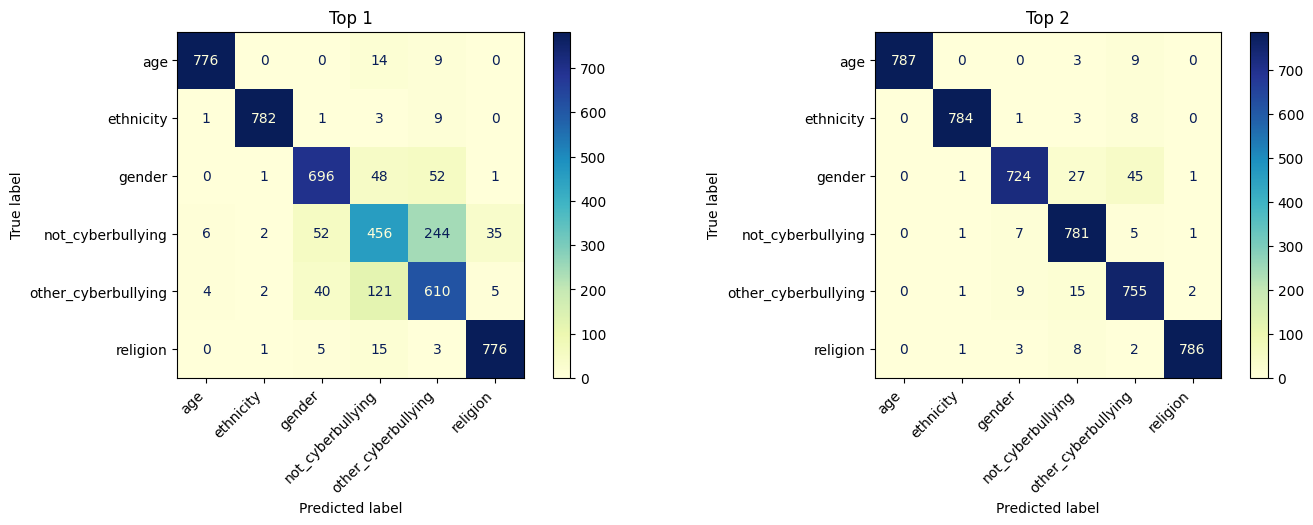

In [ ]:
plot_cfm_and_summary(*get_top1_top2(pred_bert, test_ds))

In [38]:
bilstm_model = tf.keras.models.Sequential([
    layers.Embedding(30000, 128, input_shape=[128]),
    layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(256, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dense(6, activation='softmax')
])

bilstm_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [39]:
bilstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 128, 128)            │       3,840,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128, 256)            │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128, 512)            │       1,050,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 128)                 │         295,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,449,990 (20.79 MB)

 Trainable params: 5,449,990 (20.79 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
history_bilstm = bilstm_model.fit(train_token_ds, validation_data=val_token_ds, epochs=5)

Epoch 1/5
597/597 ━━━━━━━━━━━━━━━━━━━━ 143s 236ms/step - accuracy: 0.6316 - loss: 0.8561 - val_accuracy: 0.8335 - val_loss: 0.4087
Epoch 2/5
597/597 ━━━━━━━━━━━━━━━━━━━━ 140s 235ms/step - accuracy: 0.8385 - loss: 0.3994 - val_accuracy: 0.8373 - val_loss: 0.4128
Epoch 3/5
597/597 ━━━━━━━━━━━━━━━━━━━━ 146s 242ms/step - accuracy: 0.8792 - loss: 0.3172 - val_accuracy: 0.8358 - val_loss: 0.4278
Epoch 4/5
597/597 ━━━━━━━━━━━━━━━━━━━━ 145s 242ms/step - accuracy: 0.9068 - loss: 0.2555 - val_accuracy: 0.8344 - val_loss: 0.4606
Epoch 5/5
597/597 ━━━━━━━━━━━━━━━━━━━━ 140s 235ms/step - accuracy: 0.9189 - loss: 0.2206 - val_accuracy: 0.8312 - val_loss: 0.4846


In [41]:
pred_bilstm = bilstm_model.predict(test_token_ds)

75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step


In [44]:
model_save_path = '/content/drive/MyDrive/Bi_LSTM_model/bilstm_model.keras'

# Save the model
bilstm_model.save(model_save_path)


In [46]:
weights_save_path = '/content/drive/MyDrive/Bi_LSTM_model_weights.weights.h5'

# Save the model weights
bilstm_model.save_weights(weights_save_path)


In [46]:
model_save_path = '/content/drive/MyDrive/Saved_models'


# Save the model
bilstm_model.save(model_save_path)

In [ ]:
# Define the path where you want to save the model weights
weights_save_path = '/content/drive/MyDrive/Saved_models'

# Save the model weights
bilstm_model.save_weights(weights_save_path)

In [ ]:
from tensorflow.keras.models import load_model

# Define the path where the model is saved
saved_model_path = '/content/drive/MyDrive/Saved_models'

# Load the saved model
loaded_model = load_model(saved_model_path)

# Define a function to preprocess the input text
def preprocess_input(text):
    text_sequence = tokenizer.texts_to_sequences([text])[0]

    # Pad the tokenized sequence to the maximum length
    padded_sequence = pad_list(text_sequence, 128)

    # Return the preprocessed input as a list
    return [padded_sequence]
    return text

# Define a function to classify input text using the loaded model
def classify_text(input_text):
    # Preprocess the input text
    preprocessed_text = preprocess_input(input_text)

    # Use the loaded model to predict the class probabilities
    class_probabilities = loaded_model.predict(preprocessed_text)

    # Return the predicted class probabilities
    return class_probabilities

# Example usage:
input_text = "It's a lovely day!"
predicted_probabilities = classify_text(input_text)
predicted_class = np.argmax(predicted_probabilities)
print(predicted_probabilities)
print(predicted_class)


1/1 [==============================] - 0s 76ms/step
[[0.00248748 0.00346532 0.02328766 0.39371642 0.5759843  0.00105877]]
4


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Top 1
Accuracy : 0.8293501048218029
F1 Score : 0.8260448301755164

Top 2
Accuracy : 0.9580712788259959
F1 Score : 0.9578497147385052



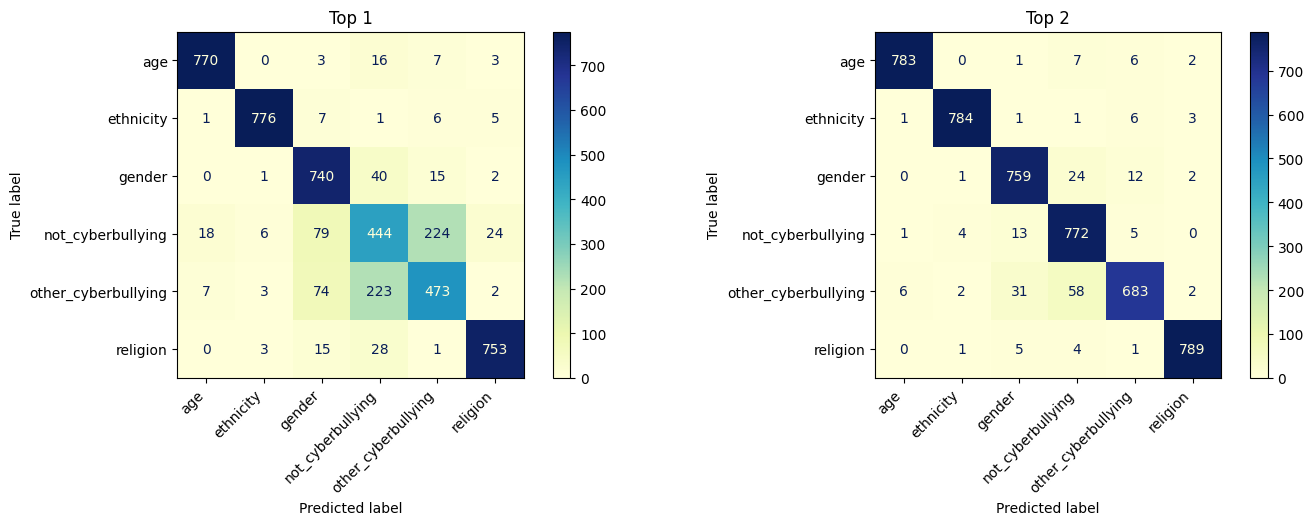

In [ ]:
plot_cfm_and_summary(*get_top1_top2(pred_bilstm, test_token_ds))

In [47]:
bigru_model = tf.keras.models.Sequential([
    layers.Embedding(30000, 128, input_shape=[128]),
    layers.Bidirectional(layers.GRU(128, return_sequences=True)),
    layers.Bidirectional(layers.GRU(256, return_sequences=True)),
    layers.Bidirectional(layers.GRU(64)),
    layers.Dense(6, activation='softmax')
    ])

In [48]:
bigru_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [49]:
bigru_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 128, 128)            │       3,840,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 128, 256)            │         198,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 128, 512)            │         789,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 128)                 │         221,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,050,374 (19.27 MB)

 Trainable params: 5,050,374 (19.27 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
history_bigru = bigru_model.fit(train_token_ds, validation_data=val_token_ds, epochs=5)

Epoch 1/5
597/597 ━━━━━━━━━━━━━━━━━━━━ 134s 224ms/step - accuracy: 0.5910 - loss: 0.9835 - val_accuracy: 0.8302 - val_loss: 0.4089
Epoch 2/5
597/597 ━━━━━━━━━━━━━━━━━━━━ 133s 222ms/step - accuracy: 0.8416 - loss: 0.3770 - val_accuracy: 0.8407 - val_loss: 0.3939
Epoch 3/5
597/597 ━━━━━━━━━━━━━━━━━━━━ 142s 222ms/step - accuracy: 0.8815 - loss: 0.2995 - val_accuracy: 0.8371 - val_loss: 0.4334
Epoch 4/5
597/597 ━━━━━━━━━━━━━━━━━━━━ 133s 222ms/step - accuracy: 0.9041 - loss: 0.2495 - val_accuracy: 0.8300 - val_loss: 0.4629
Epoch 5/5
597/597 ━━━━━━━━━━━━━━━━━━━━ 143s 223ms/step - accuracy: 0.9204 - loss: 0.2099 - val_accuracy: 0.8285 - val_loss: 0.4787


In [51]:
pred_bigru = bigru_model.predict(test_token_ds)

75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step


In [54]:
model_save_path = '/content/drive/MyDrive/Bi_GRU_model/bigru_model.keras'

# Save the model
bigru_model.save(model_save_path)


In [55]:
weights_save_path = '/content/drive/MyDrive/Bi_GRU_model_weights.weights.h5'

# Save the model weights
bilstm_model.save_weights(weights_save_path)

In [ ]:
model_save_path = '/content/drive/MyDrive/BiGRU_saved'


In [ ]:
# Save the model
bigru_model.save(model_save_path)

In [ ]:
# Define the path where you want to save the model weights
weights_save_path = '/content/drive/MyDrive/BiGRU_saved'

# Save the model weights
bigru_model.save_weights(weights_save_path)

In [ ]:
from tensorflow.keras.models import load_model

# Define the path where the model is saved
saved_model_path = '/content/drive/MyDrive/BiGRU_saved'

# Load the saved model
loaded_model = load_model(saved_model_path)

# Define a function to preprocess the input text
def preprocess_input(text):
    text_sequence = tokenizer.texts_to_sequences([text])[0]

    # Pad the tokenized sequence to the maximum length
    padded_sequence = pad_list(text_sequence, 128)

    # Return the preprocessed input as a list
    return [padded_sequence]
    return text

# Define a function to classify input text using the loaded model
def classify_text(input_text):
    # Preprocess the input text
    preprocessed_text = preprocess_input(input_text)

    # Use the loaded model to predict the class probabilities
    class_probabilities = loaded_model.predict(preprocessed_text)

    # Return the predicted class probabilities
    return class_probabilities

# Example usage:
input_text = "It's a lovely day!"
predicted_probabilities = classify_text(input_text)
predicted_class = np.argmax(predicted_probabilities)
print(predicted_probabilities)
print(predicted_class)

1/1 [==============================] - 0s 76ms/step
[[3.9434741e-04 1.7073249e-03 2.0264754e-02 4.4422495e-01 5.3318024e-01
  2.2835977e-04]]
4


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Top 1
Accuracy : 0.8238993710691824
F1 Score : 0.8233464591389136

Top 2
Accuracy : 0.9563941299790356
F1 Score : 0.9563317496674398



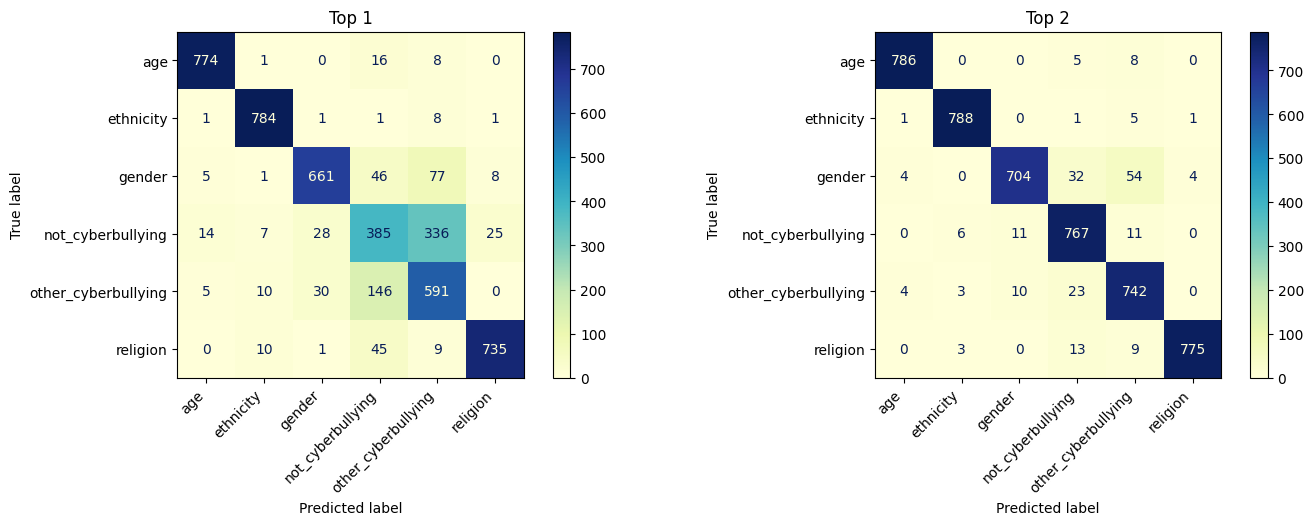

In [57]:
plot_cfm_and_summary(*get_top1_top2(pred_bigru, test_token_ds))

Top 1
Accuracy : 0.819916142557652
F1 Score : 0.8202602598256218

Top 2
Accuracy : 0.9517819706498952
F1 Score : 0.9518327301639338



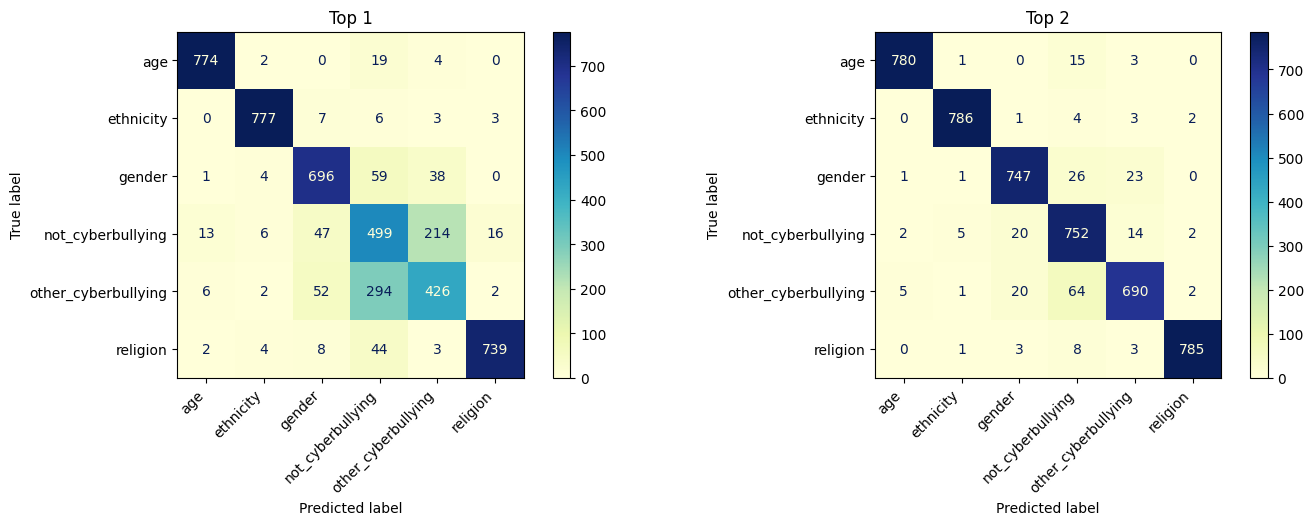

In [ ]:
plot_cfm_and_summary(*get_top1_top2(pred_bigru, test_token_ds))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
model = ['Top 1 BERT', 'Top 2 BERT', 'Top 1 Bi-LSTM', 'Top 2 Bi-LSTM', 'Top 1 Bi-GRU', 'Top 2 Bi-GRU']
scores = ['0.8536687631027253', '0.9685534591194969', '0.8251572327044026', '0.9524109014675053', '0.8111111111111111', '0.9465408805031447']
scores = [float(score) for score in scores]

In [ ]:
# prompt: randomly select 5 items from a list

import random

lst = ['Top 1 BERT', 'Top 2 BERT', 'Top 1 Bi-LSTM', 'Top 2 Bi-LSTM', 'Top 1 Bi-GRU', 'Top 2 Bi-GRU']

random_items = random.sample(lst, 5)

print(random_items)


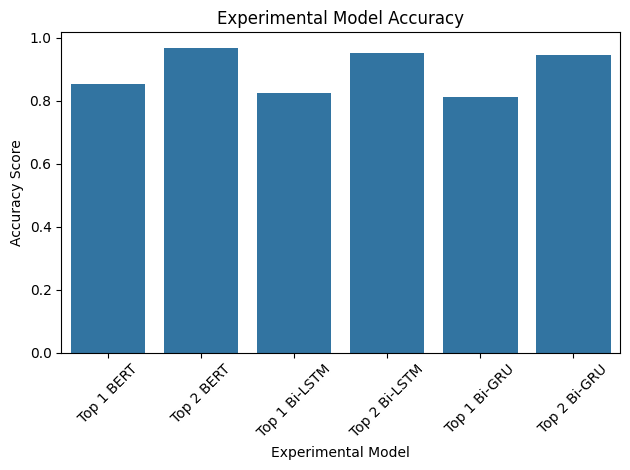

In [ ]:
sns.barplot(x=model, y=scores)
plt.xlabel('Experimental Model')
plt.ylabel('Accuracy Score')
plt.title('Experimental Model Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()